## Imports

In [1]:
import sys
sys.path.insert(0, '../')
from armadl import ARMADL

import matplotlib.pyplot as plt
import numpy as np
import pmdarima as pm
import pandas as pd
import sklearn.metrics as skm
import warnings
warnings.filterwarnings('ignore')


from random import sample, choice
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

plt.rc('figure', figsize=(16,12))

#### Loading a sample dataset
More info can be found here: http://alkaline-ml.com/pmdarima/1.7.0/_modules/pmdarima/datasets/gasoline.html

In [2]:
dataset = pd.DataFrame(pm.datasets.load_gasoline(), columns=['gasoline'])

#### Adding an exogenous varialbes based on lagged values of the target

In [3]:
dataset['exog1'] = dataset.shift(-2)/100

In [4]:
dataset['exog1'][-2:] = [93.05, 93.88]

#### Adding a random exogenous variable

In [5]:
dataset['exog2'] = abs(np.random.randn(dataset.shape[0]))

In [6]:
dataset.head()

,gasoline,exog1,exog2
0,6621.0,65.82,0.089218
1,6433.0,72.24,0.729858
2,6582.0,68.75,0.170372
3,7224.0,69.47,0.352164
4,6875.0,73.28,0.131554


In [7]:
dataset.corr()

,gasoline,exog1,exog2
gasoline,1.000000,0.838285,0.029752
exog1,0.838285,1.000000,0.008814
exog2,0.029752,0.008814,1.000000


In [8]:
dataset.shape

(745, 3)

## EDA

#### Seasonal decomposition using STL

In [9]:
dataset.index = pd.date_range("02-01-1991",periods=len(dataset),freq='W')
stl = STL(dataset['gasoline'], seasonal=53)

In [10]:
stlfit = stl.fit()

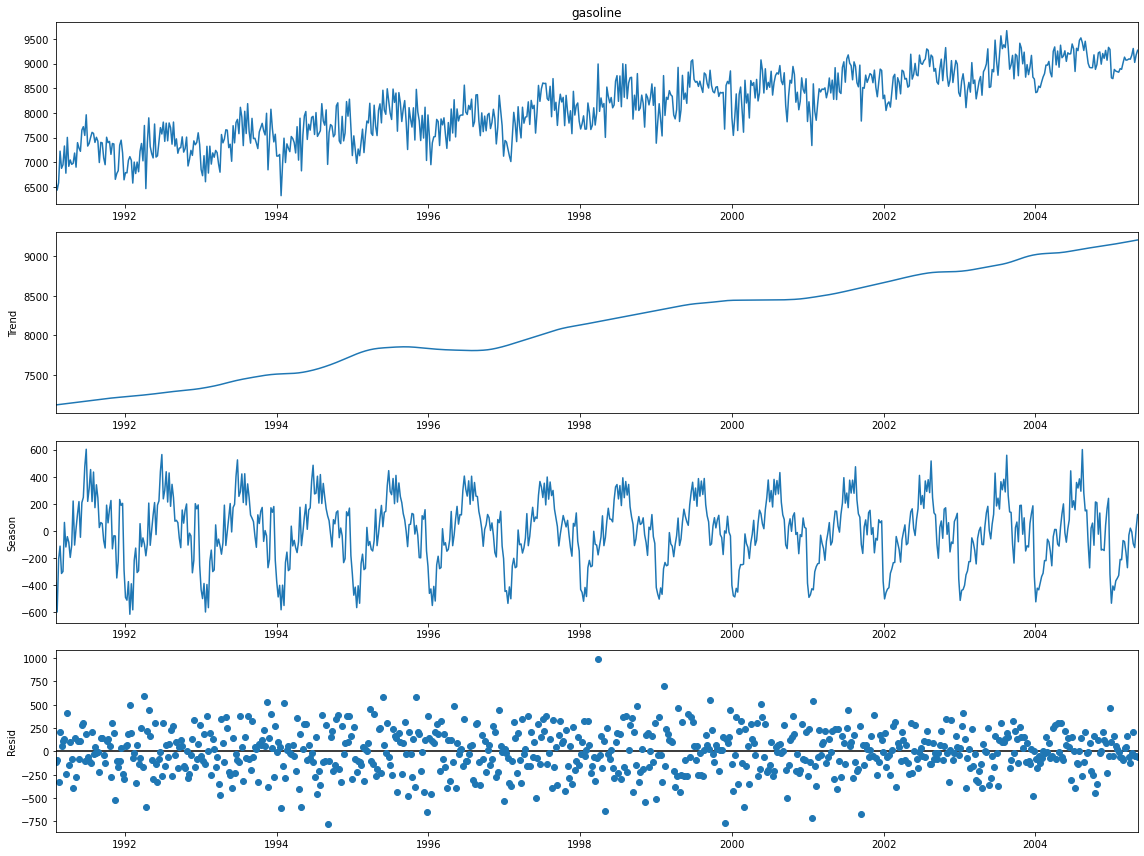

In [11]:
stlfit.plot()
plt.show()

In [12]:
# sres = seasonal_decompose(dataset['gasoline'], period=53)
# sres.plot()
# plt.show()

#### Stationarity test and ACF and PACF analyses

In [13]:
kpss_res = kpss(dataset['gasoline'], nlags='auto', regression='c')
adf_res = adfuller(dataset['gasoline'],regression='c')
print(kpss_res[1], adf_res[1])
sr_diff = dataset['gasoline']-dataset['gasoline'].shift(1)
kpss_res = kpss(sr_diff.dropna(), nlags='auto', regression='c')
adf_res = adfuller(sr_diff.dropna(), regression='c')
print(kpss_res[1], adf_res[1])

0.01 0.348160899739101
0.1 7.231136721885619e-27


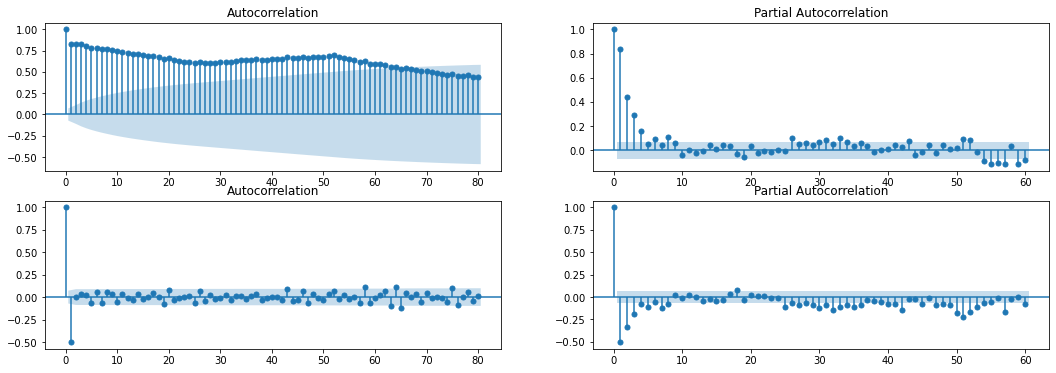

In [14]:
fig, axes = plt.subplots(2,2)
fig.set_figwidth(18)
fig.set_figheight(6)
plot_acf(dataset['gasoline'], lags=80, ax=axes[0,0])
plot_pacf(dataset['gasoline'], lags=60, ax=axes[0,1])
plot_acf(sr_diff.interpolate(limit_direction='both'), lags=80, ax=axes[1,0])
plot_pacf(sr_diff.interpolate(limit_direction='both'), lags=60, ax=axes[1,1])
plt.show()

## ARMADL test
Here the first four "seasons" from the data are chosen (weekly data, ~52 weeks per year) for train and test.

In [15]:
dl_param=1

In [16]:
mdl = ARMADL(dataset['gasoline'][:4*52], 
             exog=dataset[['exog1','exog2']][:4*52], 
             dl_param=dl_param) #dl_param={'exog1':[1,2], 'exog2':2})

#### Important!
ARMADL primarily works as a wrapper for the pmdarima's model selection function named *auto_arima*. Therefore, all the auto_arima() function parameters should be provided. Details on auto_arima() can be found here: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [17]:
auto_arima_params = dict(start_p=0, start_q=0, with_intercept=True,
                       test='adf', trace=True, stepwise=False, seasonal=True, out_of_sample_size=52,
                       scoring='mse', m=52, maxiter=5)

In [18]:
endog = dataset['gasoline']
exog = dataset[['exog1','exog2']]

In [19]:
mdl.exog.head()

,exog1,exog1_1,exog2,exog2_1
1991-02-03,65.82,0.00,0.089218,0.000000
1991-02-10,72.24,65.82,0.729858,0.089218
1991-02-17,68.75,72.24,0.170372,0.729858
1991-02-24,69.47,68.75,0.352164,0.170372
1991-03-03,73.28,69.47,0.131554,0.352164


#### ARMADL model selection where distributed lags are included.

In [20]:
res = mdl.model_selection(strategy='split', 
                          train_size=3*52, 
                          get_results=True, 
                          use_pretrained=True, 
                          store_model=False, 
                          model_path='trained_model_L1.pckl',
                          **auto_arima_params)

In [21]:
mdl.exog.shape

(208, 4)

In [22]:
train_endog, train_preds, test_endog, test_preds = res

#### Calculating MAPE

In [23]:
skm.mean_absolute_percentage_error(train_endog, train_preds)

0.0412397077018986

In [24]:
skm.mean_absolute_percentage_error(test_endog, test_preds)

0.04043310692423168

#### The fitted model is stored in a list and can be retrieved.

In [25]:
fit_res = mdl.fit_res[0]

In [26]:
fit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  156
Model:             SARIMAX(0, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1124.556
Date:                             Sat, 18 Sep 2021   AIC                           2267.113
Time:                                     02:15:58   BIC                           2294.561
Sample:                                          0   HQIC                          2278.261
                                             - 156                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.9614    277.882      0.068      0.946    -525.676     563.599
x1            89.2212      5.379     16.588      0.000      78.679      99.763
x2            10.7103      2.178      4.917      0.000       6.441      14.980
x3           -89.7399     34.169     -2.626      0.009    -156.709     -22.770
x4            64.3941     30.885      2.085      0.037       3.862     124.927
ma.L1          0.0156      0.058      0.270      0.788      -0.098       0.129
ma.L2         -0.6044      0.064     -9.470      0.000      -0.729      -0.479
ar.S.L52       0.2050      0.105      1.950      0.051      -0.001       0.411
sigma2      8.711e+04   8563.373     10.173      0.000    7.03e+04    1.04e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.55   Prob(JB):                         0.56
Heteroskedasticity (H):               1.49   Skew:                            -0.12
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plotting true vs predicted values
Note that here one must figure out the values of the exogenous variable(s). If model selection has been performed, the exogenous variables can be extracted from the ARMADL object. Otherwise, they can be calculated since the class provides a static function for that.

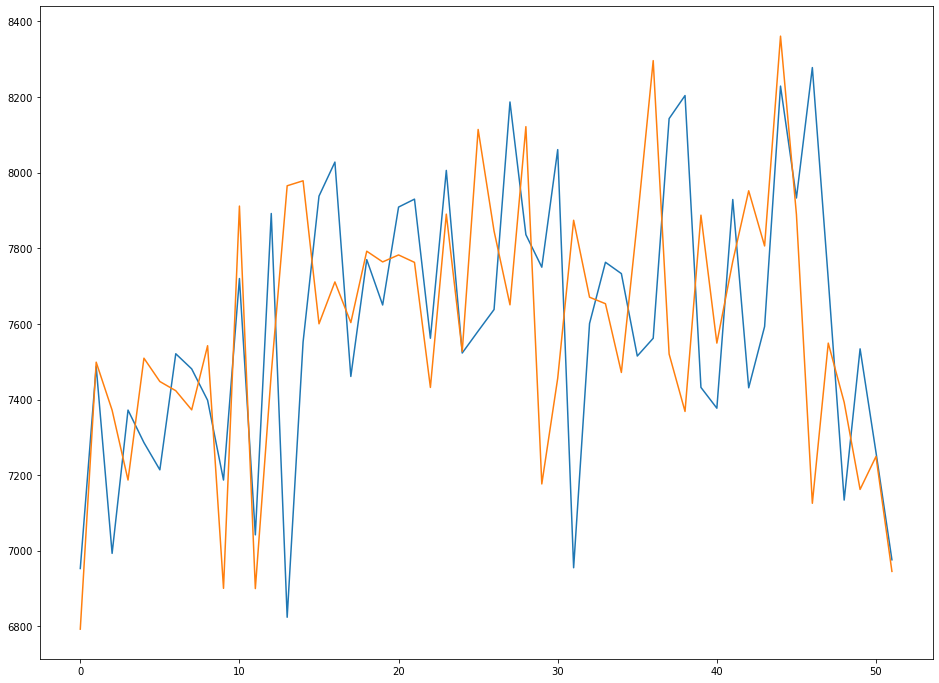

In [27]:
#for next season after training
start=3*52
end=4*52
test_true = dataset['gasoline'][start:end].values

#if model selection has already been performed
exog_vals = mdl.exog[start:end] 

#alternatively, one can re-run the function to get the exogenous variables
#exog_vals = mdl.generate_distributed_lags(exog=dataset[['exog1','exog2']][start:end],k=dl_param)

test_preds = fit_res.predict(n_periods=(end-start), X=exog_vals)
plt.plot(test_true)
plt.plot(test_preds)

In [28]:
skm.mean_absolute_percentage_error(test_endog, test_preds)

0.04043310692423168

In [29]:
mdl.best_params

[[0, 0, 2, 52]]

In [30]:
# Manually testing the best parameters using SARIMAX
#model = SARIMAX(dataset['gasoline'][:3*52], exog=dataset[['exog1','exog2']][:3*52], 
#                order=fit_res.order, seasonal_order=fit_res.seasonal_order)
#modelres = model.fit()
#modelres.summary()